In [30]:
# Import additional required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [31]:
%pip install seaborn scikit-learn pandas numpy matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
used_car_data_path = "C:/Users/Hi/Downloads/data-1741703458179.csv"
used_car_df = pd.read_csv(used_car_data_path)

In [33]:
used_car_df.head(5)

,Year of Manufacture,Car Make,Car Full Title,Cash Price (USD),Down Payment,Installment Per Month,Loan Term (Months),Interest Rate (APR),Exterior,Interior,Mileage,Fuel Type,MPG,Transmission,Drivetrain,Engine,Location,Listed Since,VIN,Stock Number,Features
0,2006,Acura,2006 Acura TL Automatic,"4,995",NaN,NaN,NaN,NaN,Silver,Black,"195,699",Gas,20 city / 29 highway,Automatic Transmission,FWD,3.2L V-6 Gas V,"Las Vegas, NV",18 days ago,19UUA66236A051751,9644R,Child Safety Door Locks; Power Door Locks; Veh...
1,2014,Honda,2014 Honda Civic LX Sedan CVT,"10,900",NaN,NaN,NaN,NaN,Taffeta White,Gray,"70,996",Gas,30 city / 39 highway,Automatic Transmission,FWD,1.8L Inline-4 Gas Inline,"South Chesterfield, VA",19 days ago,19XFB2F51EE009632,009632,Wheel Type; Backup Camera; Bluetooth; Traction...
2,2012,Honda,2012 Honda Civic LX Sedan Automatic,"5,995",NaN,NaN,NaN,NaN,Taffeta White,Gray,"158,731",Gas,28 city / 39 highway,Automatic Transmission,FWD,1.8L Inline-4 Gas Inline,"San Antonio, TX",18 days ago,19XFB2F52CE321097,9072,NaN
3,2015,Honda,2015 Honda Civic LX Sedan CVT,"4,999",NaN,NaN,NaN,NaN,Gray,Gray,"240,591",Gas,30 city / 39 highway,Automatic Transmission,FWD,1.8L Inline-4 Gas Inline,"Tampa, FL",12 days ago,19XFB2F52FE026960,FE026960T,Wheel Type; Backup Camera; Bluetooth; Driver A...
4,2015,Honda,2015 Honda Civic SE Sedan CVT,"8,500",NaN,NaN,NaN,NaN,Crystal Black Pearl,Gray,"133,761",Gas,30 city / 39 highway,Automatic Transmission,FWD,1.8L Inline-4 Gas Inline,"San Antonio, TX",28 days ago,19XFB2F72FE088750,088750,Wheel Type; Backup Camera; Bluetooth; Power St...


In [34]:
used_car_df.describe()

,Year of Manufacture,Installment Per Month,Loan Term (Months),Interest Rate (APR)
count,1495.000000,958.000000,976.000000,976.000000
mean,2017.788629,284.509395,71.913934,7.388566
std,4.528595,168.558662,1.013129,0.016885
min,1997.000000,1.000000,60.000000,7.190000
25%,2015.000000,155.250000,72.000000,7.390000
50%,2018.000000,250.000000,72.000000,7.390000
75%,2021.000000,370.000000,72.000000,7.390000
max,2024.000000,991.000000,72.000000,7.390000


In [35]:
used_car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1495 entries, 0 to 1494
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year of Manufacture    1495 non-null   int64  
 1   Car Make               1495 non-null   object 
 2   Car Full Title         1495 non-null   object 
 3   Cash Price (USD)       1495 non-null   object 
 4   Down Payment           976 non-null    object 
 5   Installment Per Month  958 non-null    float64
 6   Loan Term (Months)     976 non-null    float64
 7   Interest Rate (APR)    976 non-null    float64
 8   Exterior               1495 non-null   object 
 9   Interior               1495 non-null   object 
 10  Mileage                1495 non-null   object 
 11  Fuel Type              1495 non-null   object 
 12  MPG                    1223 non-null   object 
 13  Transmission           1495 non-null   object 
 14  Drivetrain             1495 non-null   object 
 15  Engi

In [36]:
used_car_df["Location"].value_counts()

Location
Houston, TX           74
San Antonio, TX       27
Tampa, FL             27
Dallas, TX            25
Orlando, FL           24
                      ..
Dothan, AL             1
Morgan, UT             1
Kenosha, WI            1
La Grange, GA          1
St. Petersburg, FL     1
Name: count, Length: 577, dtype: int64

In [37]:
# Add progress tracking
from tqdm import tqdm
tqdm.pandas()

def clean_car_data_with_financing(df):
    """
    Clean and preprocess the car dataset with enhanced error handling and data validation.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing car data
        
    Returns:
    --------
    pandas.DataFrame
        Cleaned and preprocessed dataframe
        
    Raises:
    -------
    ValueError
        If required columns are missing
    """
    try:
        # Create a copy of the dataframe
        clean_df = df.copy()
        
        # Validate required columns
        required_columns = ['Cash Price (USD)', 'Mileage', 'MPG']
        missing_columns = [col for col in required_columns if col not in clean_df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")
        
        # Handle NULL values
        clean_df = clean_df.replace(['NULL', 'null', 'Null', 'NA', 'na', 'N/A', 'n/a'], np.nan)
        
        # Process financing columns
        loan_columns = ['Down Payment', 'Installment Per Month', 'Loan Term (Months)', 'Interest Rate (APR)']
        clean_df['Financing Support'] = clean_df[loan_columns].notnull().any(axis=1).map({True: 'Yes', False: 'No'})
        clean_df= clean_df.drop(columns=loan_columns)
        # Clean numeric columns with error handling
        numeric_columns = {
            'Cash Price (USD)': 'price',
            'Mileage': 'mileage'
        }
        
        for col, col_type in numeric_columns.items():
            try:
                # Convert to string first to handle any formatting issues
                clean_df[col] = clean_df[col].astype(str)
                # Remove non-numeric characters except decimal point
                clean_df[col] = clean_df[col].str.replace(r"[^0-9.]", "", regex=True)
                # Convert to numeric, coercing errors to NaN
                clean_df[col] = pd.to_numeric(clean_df[col], errors='coerce')
                
                # Add validation for reasonable ranges
                if col_type == 'price':
                    clean_df = clean_df[clean_df[col] > 0]  # Remove negative or zero prices
                elif col_type == 'mileage':
                    clean_df = clean_df[clean_df[col] >= 0]  # Allow zero mileage for new cars
            except Exception as e:
                print(f"Warning: Error processing {col}: {str(e)}")
        
        # Create price categories with validation
        price_bins = [0, 5000, 15000, 30000, 60000, float("inf")]
        price_labels = ["Budget (<5K)", "Affordable (5K-15K)", "Mid-range (15K-30K)",
                       "Premium (30K-60K)", "Luxury (>60K)"]
        clean_df["Price Category"] = pd.cut(clean_df["Cash Price (USD)"], 
                                          bins=price_bins, 
                                          labels=price_labels, 
                                          right=False)
        
        # Process MPG data with validation
        if 'MPG' in clean_df.columns:
            try:
                mpg_pattern = r'(\d+) city / (\d+) highway'
                mpg_data = clean_df['MPG'].str.extract(mpg_pattern)
                clean_df['City MPG'] = pd.to_numeric(mpg_data[0], errors='coerce')
                clean_df['Highway MPG'] = pd.to_numeric(mpg_data[1], errors='coerce')
                
                # Validate MPG values
                clean_df = clean_df[
                    (clean_df['City MPG'].between(0, 100)) & 
                    (clean_df['Highway MPG'].between(0, 100))
                ]
            except Exception as e:
                print(f"Warning: Error processing MPG data: {str(e)}")
        
        # Process year data with validation
        if 'Year of Manufacture' in clean_df.columns:
            try:
                clean_df['Year of Manufacture'] = pd.to_numeric(clean_df['Year of Manufacture'], errors='coerce')
                current_year = pd.Timestamp.now().year
                clean_df = clean_df[
                    (clean_df['Year of Manufacture'] >= 1900) & 
                    (clean_df['Year of Manufacture'] <= current_year + 1)
                ]
            except Exception as e:
                print(f"Warning: Error processing Year of Manufacture: {str(e)}")
        
        # Standardize text columns
        text_cols = ['Car Make', 'Car Full Title', 'Exterior', 'Interior', 'Fuel Type',
                    'Transmission', 'Drivetrain', 'Engine', 'Location']
        for col in text_cols:
            if col in clean_df.columns:
                clean_df[col] = clean_df[col].str.strip().str.title()
        
        # Add data quality metrics
        clean_df.attrs['data_quality'] = {
            'total_rows': len(clean_df),
            'missing_values': clean_df.isnull().sum().to_dict(),
            'price_range': {
                'min': clean_df['Cash Price (USD)'].min(),
                'max': clean_df['Cash Price (USD)'].max(),
                'mean': clean_df['Cash Price (USD)'].mean()
            }
        }
        
        return clean_df
        
    except Exception as e:
        print(f"Error in data cleaning: {str(e)}")
        raise

In [38]:
cleaned_df = clean_car_data_with_financing(used_car_df)

In [39]:
print(cleaned_df.head(1).T)

                                                                     0
Year of Manufacture                                               2006
Car Make                                                         Acura
Car Full Title                                 2006 Acura Tl Automatic
Cash Price (USD)                                                  4995
Exterior                                                        Silver
Interior                                                         Black
Mileage                                                         195699
Fuel Type                                                          Gas
MPG                                               20 city / 29 highway
Transmission                                    Automatic Transmission
Drivetrain                                                         Fwd
Engine                                                  3.2L V-6 Gas V
Location                                                 Las Vegas, Nv
Listed

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def categorize_car_prices(df):
    # Create a copy of the dataframe
    categorized_df = df.copy()

    # Ensure the price column is numeric
    categorized_df['Cash Price (USD)'] = pd.to_numeric(categorized_df['Cash Price (USD)'], errors='coerce')

    # Add a price category column based on suggested thresholds
    price_bins = [0, 5000, 15000, 30000, 60000, float('inf')]
    price_labels = ['Budget / Used', 'Affordable', 'Mid-range', 'Premium', 'Luxury / Supercar']

    categorized_df['Price Segment'] = pd.cut(
        categorized_df['Cash Price (USD)'],
        bins=price_bins,
        labels=price_labels,
        right=True
    )

    # Count the number of cars in each price segment
    price_segment_stats = categorized_df['Price Segment'].value_counts().sort_index()

    # Analyze price segments by car brand
    price_segment_by_make = pd.crosstab(
        categorized_df['Car Make'],
        categorized_df['Price Segment'],
        normalize='index'
    ) * 100

    # Analyze price segments by year of manufacture
    price_segment_by_year = pd.crosstab(
        categorized_df['Year of Manufacture'],
        categorized_df['Price Segment'],
        normalize='index'
    ) * 100

    # Analyze the relationship between price segments and financing support
    if 'Financing Support' in categorized_df.columns:
        price_segment_financing = pd.crosstab(
            categorized_df['Price Segment'],
            categorized_df['Financing Support'],
            normalize='index'
        ) * 100
    else:
        price_segment_financing = None

    # Compile analysis results
    price_segment_analysis = {
        'number_of_cars_per_segment': price_segment_stats,
        'percentage_by_make': price_segment_by_make,
        'percentage_by_year': price_segment_by_year,
        'percentage_financing_support_by_segment': price_segment_financing
    }

    return categorized_df, price_segment_analysis

def visualize_price_segments(categorized_df):
    # Generate various charts for analyzing car price segments
    plt.figure(figsize=(15, 10))

    # 1. Distribution of cars by price segment
    plt.subplot(2, 2, 1)
    sns.countplot(y='Price Segment', data=categorized_df, order=categorized_df['Price Segment'].value_counts().index)
    plt.title('Number of Cars by Price Segment')
    plt.xlabel('Number of Cars')
    plt.ylabel('Price Segment')

    # 2. Price segments by car brand
    plt.subplot(2, 2, 2)
    price_segment_by_make = pd.crosstab(categorized_df['Car Make'], categorized_df['Price Segment'])
    price_segment_by_make.plot(kind='barh', stacked=True, ax=plt.gca())
    plt.title('Price Segments by Car Brand')
    plt.xlabel('Number of Cars')
    plt.ylabel('Car Brand')

    # 3. Price segments by year of manufacture
    plt.subplot(2, 2, 3)
    price_segment_by_year = pd.crosstab(categorized_df['Year of Manufacture'], categorized_df['Price Segment'])
    price_segment_by_year.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title('Price Segments by Year of Manufacture')
    plt.xlabel('Year of Manufacture')
    plt.ylabel('Number of Cars')
    plt.xticks(rotation=45)

    # 4. Relationship between price segment and mileage
    plt.subplot(2, 2, 4)
    sns.boxplot(x='Price Segment', y='Mileage', data=categorized_df)
    plt.title('Mileage by Price Segment')
    plt.xlabel('Price Segment')
    plt.ylabel('Mileage')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Generate additional charts if financing support data is available
    if 'Financing Support' in categorized_df.columns:
        plt.figure(figsize=(15, 5))

        # Relationship between price segment and financing support
        plt.subplot(1, 2, 1)
        financing_by_segment = pd.crosstab(categorized_df['Price Segment'], categorized_df['Financing Support'])
        financing_by_segment.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Financing Support by Price Segment')
        plt.xlabel('Price Segment')
        plt.ylabel('Number of Cars')
        plt.xticks(rotation=45)

        # Percentage of financing support by price segment
        plt.subplot(1, 2, 2)
        financing_pct_by_segment = pd.crosstab(
            categorized_df['Price Segment'],
            categorized_df['Financing Support'],
            normalize='index'
        ) * 100
        financing_pct_by_segment.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Percentage of Financing Support by Price Segment (%)')
        plt.xlabel('Price Segment')
        plt.ylabel('Percentage (%)')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    return None


In [41]:
categorized_df, price_segment_analysis = categorize_car_prices(cleaned_df)

In [42]:
price_segment_analysis

{'number_of_cars_per_segment': Price Segment
 Budget / Used         40
 Affordable           686
 Mid-range            414
 Premium               70
 Luxury / Supercar     11
 Name: count, dtype: int64,
 'percentage_by_make': Price Segment  Budget / Used  Affordable  Mid-range    Premium  \
 Car Make                                                         
 Acura              33.333333   66.666667   0.000000   0.000000   
 Aston               0.000000    0.000000   0.000000  50.000000   
 Audi                6.250000   50.000000  31.250000   6.250000   
 Bmw                 4.411765   41.176471  47.058824   5.882353   
 Buick               0.000000   80.000000  20.000000   0.000000   
 Cadillac            9.090909   45.454545  45.454545   0.000000   
 Chevrolet           2.564103   58.119658  38.461538   0.854701   
 Chrysler           10.526316   52.631579  31.578947   5.263158   
 Dodge               4.000000   76.000000  20.000000   0.000000   
 Fiat              100.000000    0.000

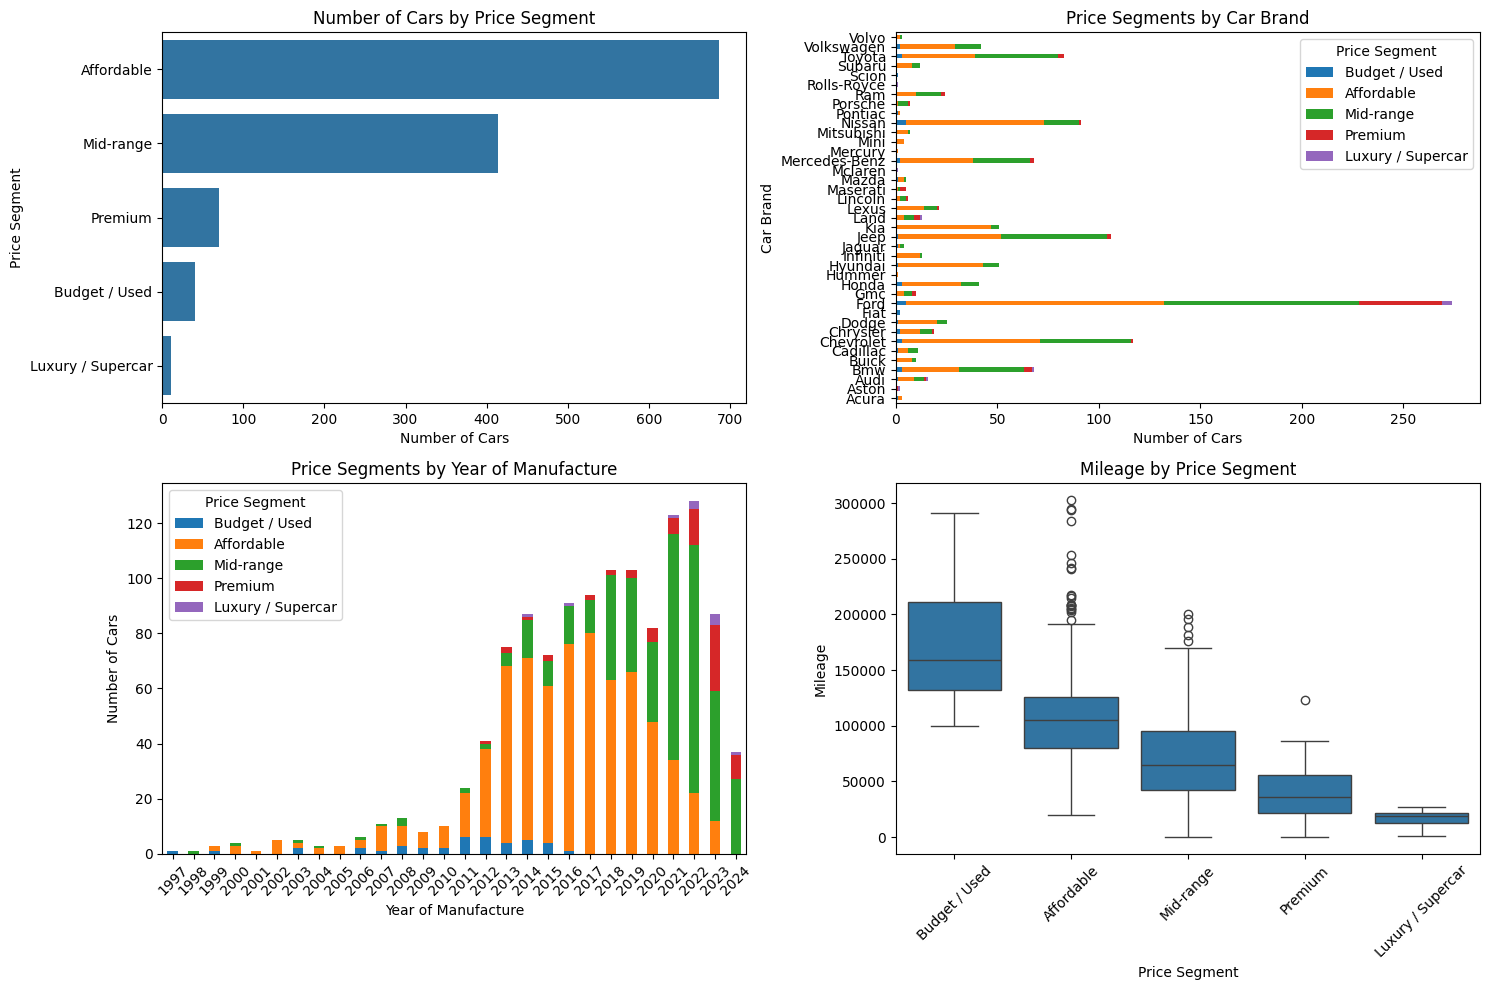

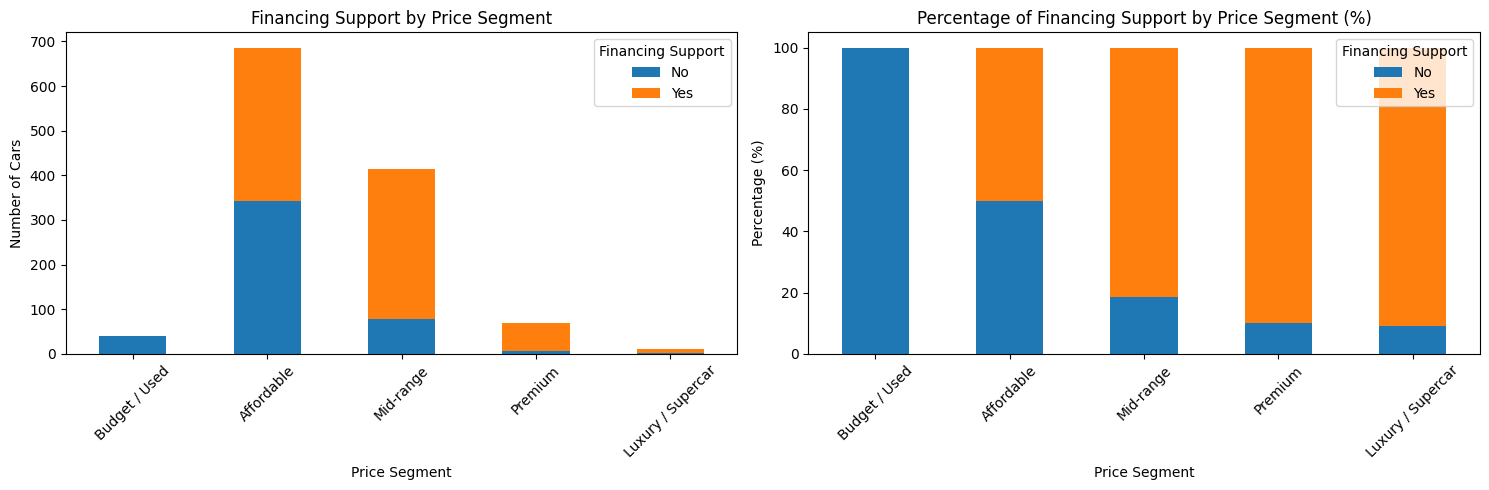

In [43]:
visualize_price_segments(categorized_df)

In [44]:
def extract_state(location):
    """
    Extract state from location string with improved pattern matching.
    
    Parameters:
    -----------
    location : str
        Location string (e.g., "Las Vegas, NV", "New York, NY", "Los Angeles, California")
        
    Returns:
    --------
    str
        Two-letter state code or full state name
    """
    if pd.isna(location):
        return None
        
    # Dictionary of full state names to abbreviations
    state_dict = {
        'alabama': 'AL', 'alaska': 'AK', 'arizona': 'AZ', 'arkansas': 'AR', 'california': 'CA',
        'colorado': 'CO', 'connecticut': 'CT', 'delaware': 'DE', 'florida': 'FL', 'georgia': 'GA',
        'hawaii': 'HI', 'idaho': 'ID', 'illinois': 'IL', 'indiana': 'IN', 'iowa': 'IA',
        'kansas': 'KS', 'kentucky': 'KY', 'louisiana': 'LA', 'maine': 'ME', 'maryland': 'MD',
        'massachusetts': 'MA', 'michigan': 'MI', 'minnesota': 'MN', 'mississippi': 'MS',
        'missouri': 'MO', 'montana': 'MT', 'nebraska': 'NE', 'nevada': 'NV', 'new hampshire': 'NH',
        'new jersey': 'NJ', 'new mexico': 'NM', 'new york': 'NY', 'north carolina': 'NC',
        'north dakota': 'ND', 'ohio': 'OH', 'oklahoma': 'OK', 'oregon': 'OR', 'pennsylvania': 'PA',
        'rhode island': 'RI', 'south carolina': 'SC', 'south dakota': 'SD', 'tennessee': 'TN',
        'texas': 'TX', 'utah': 'UT', 'vermont': 'VT', 'virginia': 'VA', 'washington': 'WA',
        'west virginia': 'WV', 'wisconsin': 'WI', 'wyoming': 'WY'
    }
    
    # Convert to lowercase for consistent matching
    location = location.lower()

    # Reverse the dictionary to map state codes to full names
    state_code_to_name = {v.lower(): k for k, v in state_dict.items()}

    # Try to match two-letter state code at the end
    state_match = re.search(r',\s*([a-z]{2})\s*$', location)
    if state_match:
        state_code = state_match.group(1).upper()
        return state_code_to_name.get(state_code.lower(), state_code)  # Return full state name if found

    # Try to match full state name
    for state_name, state_code in state_dict.items():
        if state_code.lower() in location or state_name in location:
            return state_name  # Return full state name

    return None

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
def analyze_price_segments_comprehensive(df):
    # Ensure that car prices are categorized
    if 'Price Segment' not in df.columns:
        price_bins = [0, 5000, 15000, 30000, 60000, float('inf')]
        price_labels = ['Budget / Used', 'Affordable', 'Mid-range', 'Premium', 'Luxury / Supercar']

        df['Price Segment'] = pd.cut(
            pd.to_numeric(df['Cash Price (USD)'], errors='coerce'),
            bins=price_bins,
            labels=price_labels,
            right=True
        )

    # Detailed analysis of characteristics by price segment
    comprehensive_analysis = {}

    # 1. Average MPG by price segment
    if 'City MPG' in df.columns and 'Highway MPG' in df.columns:
        mpg_by_segment = df.groupby('Price Segment')[['City MPG', 'Highway MPG']].mean()
        comprehensive_analysis['fuel_consumption_by_segment'] = mpg_by_segment

    # 2. Analysis of fuel type by price segment
    if 'Fuel Type' in df.columns:
        fuel_by_segment = pd.crosstab(df['Price Segment'], df['Fuel Type'], normalize='index') * 100
        comprehensive_analysis['fuel_type_by_segment'] = fuel_by_segment

    # 3. Analysis of transmission type by price segment
    if 'Transmission' in df.columns:
        transmission_by_segment = pd.crosstab(df['Price Segment'], df['Transmission'], normalize='index') * 100
        comprehensive_analysis['transmission_by_segment'] = transmission_by_segment

    # 4. Analysis of drivetrain type by price segment
    if 'Drivetrain' in df.columns:
        drivetrain_by_segment = pd.crosstab(df['Price Segment'], df['Drivetrain'], normalize='index') * 100
        comprehensive_analysis['drivetrain_by_segment'] = drivetrain_by_segment

    # 5. Analysis of exterior color by price segment
    if 'Exterior' in df.columns:
        # Get the 5 most popular colors
        top_colors = df['Exterior'].value_counts().nlargest(5).index
        # Assign top 5 colors, others labeled as "Other"
        df['Top Exterior Color'] = df['Exterior'].apply(lambda x: x if x in top_colors else 'Other')
        # Analysis
        exterior_by_segment = pd.crosstab(df['Price Segment'], df['Top Exterior Color'], normalize='index') * 100
        comprehensive_analysis['exterior_color_by_segment'] = exterior_by_segment

    # 6. Analysis of listing location by price segment
    if 'Location' in df.columns:
        df['State'] = df['Location'].apply(extract_state)
        # Get the 5 most common states
        top_states = df['State'].value_counts().nlargest(5).index
        # Assign top 5 states, others labeled as "Other"
        df['Top State'] = df['State'].apply(lambda x: x if x in top_states else 'Unmatched')
        # Analysis
        location_by_segment = pd.crosstab(df['Price Segment'], df['Top State'], normalize='index') * 100
        comprehensive_analysis['location_by_segment'] = location_by_segment

    # 7. Average listing duration by price segment
    if 'Listed Since' in df.columns:
        # Extract listing duration in days
        df['Listed Days'] = df['Listed Since'].str.extract(r'(\d+)').astype(float)
        listing_days_by_segment = df.groupby('Price Segment')['Listed Days'].mean()
        comprehensive_analysis['listing_days_by_segment'] = listing_days_by_segment

    # 8. Correlation between price segment and mileage
    mileage_by_segment = df.groupby('Price Segment')['Mileage'].agg(['mean', 'median', 'min', 'max', 'count'])
    comprehensive_analysis['mileage_by_segment'] = mileage_by_segment

    return comprehensive_analysis


In [46]:
analyze_price_segments_comprehensive(cleaned_df)

{'fuel_consumption_by_segment':                     City MPG  Highway MPG
 Price Segment                            
 Budget / Used      22.400000    30.975000
 Affordable         22.626822    30.055394
 Mid-range          21.251208    27.485507
 Premium            17.600000    22.414286
 Luxury / Supercar  15.000000    20.000000,
 'fuel_type_by_segment': Fuel Type            Diesel         Gas    Hybrid  Hydrogen  Plug-In Hybrid
 Price Segment                                                              
 Budget / Used      0.000000  100.000000  0.000000   0.00000        0.000000
 Affordable         0.291545   96.793003  2.186589   0.58309        0.145773
 Mid-range          0.724638   96.376812  2.898551   0.00000        0.000000
 Premium            0.000000   94.285714  5.714286   0.00000        0.000000
 Luxury / Supercar  0.000000  100.000000  0.000000   0.00000        0.000000,
 'transmission_by_segment': Transmission       Automatic Transmission  Manual Transmission
 Price Segme

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_comprehensive_price_segment_analysis(df):
    # Ensure the price segments are classified
    if 'Price Segment' not in df.columns:
        price_bins = [0, 5000, 15000, 30000, 60000, float('inf')]
        price_labels = ['Cheap / Used Cars', 'Popular Cars', 'Mid-range Cars', 'Luxury Cars', 'High-end / Supercars']

        df['Price Segment'] = pd.cut(
            pd.to_numeric(df['Cash Price (USD)'], errors='coerce'),
            bins=price_bins,
            labels=price_labels,
            right=True
        )

    # Create multiple analysis charts
    # Chart 1: MPG and Mileage by price segment
    plt.figure(figsize=(15, 10))

    # MPG by price segment
    if 'City MPG' in df.columns and 'Highway MPG' in df.columns:
        plt.subplot(2, 2, 1)
        mpg_data = df.groupby('Price Segment')[['City MPG', 'Highway MPG']].mean().reset_index()
        mpg_data_melted = pd.melt(mpg_data, id_vars=['Price Segment'],
                               value_vars=['City MPG', 'Highway MPG'],
                               var_name='MPG Type', value_name='MPG')
        sns.barplot(x='Price Segment', y='MPG', hue='MPG Type', data=mpg_data_melted)
        plt.title('Average MPG by Price Segment')
        plt.xlabel('Price Segment')
        plt.ylabel('Average MPG')
        plt.xticks(rotation=45)
        plt.legend(title='MPG Type')

    # Mileage by price segment
    plt.subplot(2, 2, 2)
    sns.boxplot(x='Price Segment', y='Mileage', data=df)
    plt.title('Mileage Distribution by Price Segment')
    plt.xlabel('Price Segment')
    plt.ylabel('Mileage')
    plt.xticks(rotation=45)
    plt.yscale('log')  # Use logarithmic scale for mileage

    # Chart 2: Fuel type by price segment
    if 'Fuel Type' in df.columns:
        plt.subplot(2, 2, 3)
        fuel_data = pd.crosstab(df['Price Segment'], df['Fuel Type'], normalize='index') * 100
        fuel_data.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Fuel Type Distribution by Price Segment')
        plt.xlabel('Price Segment')
        plt.ylabel('Percentage (%)')
        plt.xticks(rotation=45)
        plt.legend(title='Fuel Type')

    # Chart 3: Transmission type by price segment
    if 'Transmission' in df.columns:
        plt.subplot(2, 2, 4)
        transmission_data = pd.crosstab(df['Price Segment'], df['Transmission'], normalize='index') * 100
        transmission_data.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Transmission Type Distribution by Price Segment')
        plt.xlabel('Price Segment')
        plt.ylabel('Percentage (%)')
        plt.xticks(rotation=45)
        plt.legend(title='Transmission Type')

    plt.tight_layout()
    plt.show()

    # Chart 4: Drivetrain and Exterior Color by price segment
    plt.figure(figsize=(15, 10))

    # Drivetrain by price segment
    if 'Drivetrain' in df.columns:
        plt.subplot(2, 2, 1)
        drivetrain_data = pd.crosstab(df['Price Segment'], df['Drivetrain'], normalize='index') * 100
        drivetrain_data.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Drivetrain Distribution by Price Segment')
        plt.xlabel('Price Segment')
        plt.ylabel('Percentage (%)')
        plt.xticks(rotation=45)
        plt.legend(title='Drivetrain Type')

    # Exterior color by price segment
    if 'Exterior' in df.columns:
        plt.subplot(2, 2, 2)
        # Get the 5 most common colors
        top_colors = df['Exterior'].value_counts().nlargest(5).index
        # Create a column for top 5 colors
        df['Top Exterior Color'] = df['Exterior'].apply(lambda x: x if x in top_colors else 'Other')
        # Analysis
        exterior_data = pd.crosstab(df['Price Segment'], df['Top Exterior Color'], normalize='index') * 100
        exterior_data.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Exterior Color Distribution by Price Segment')
        plt.xlabel('Price Segment')
        plt.ylabel('Percentage (%)')
        plt.xticks(rotation=45)
        plt.legend(title='Exterior Color')

    plt.tight_layout()
    plt.show()


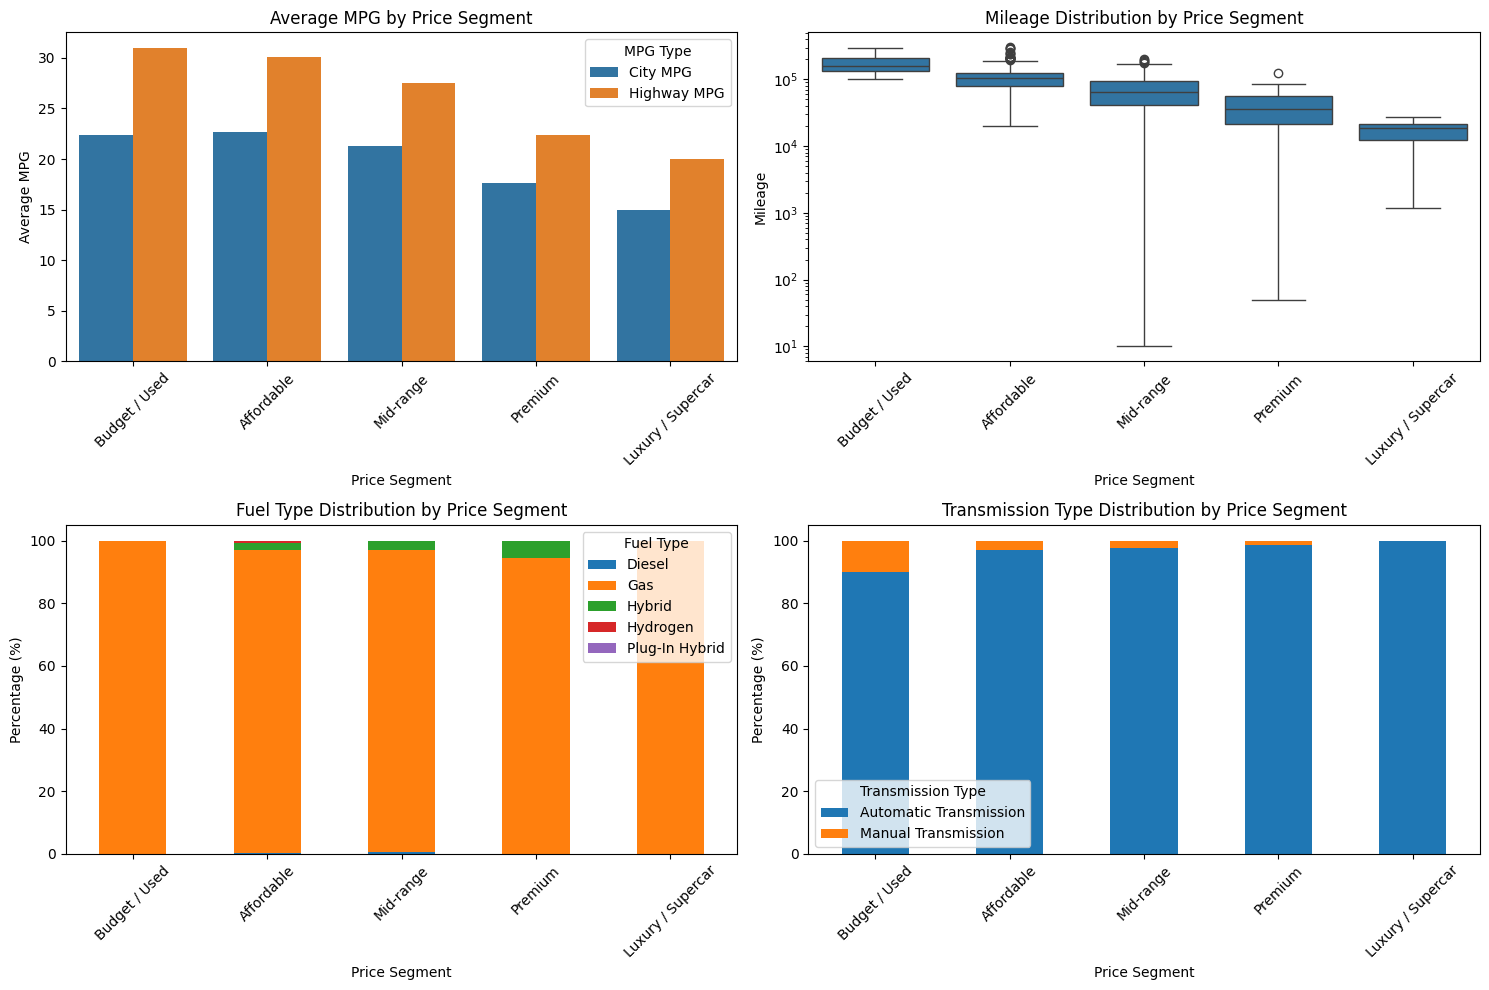

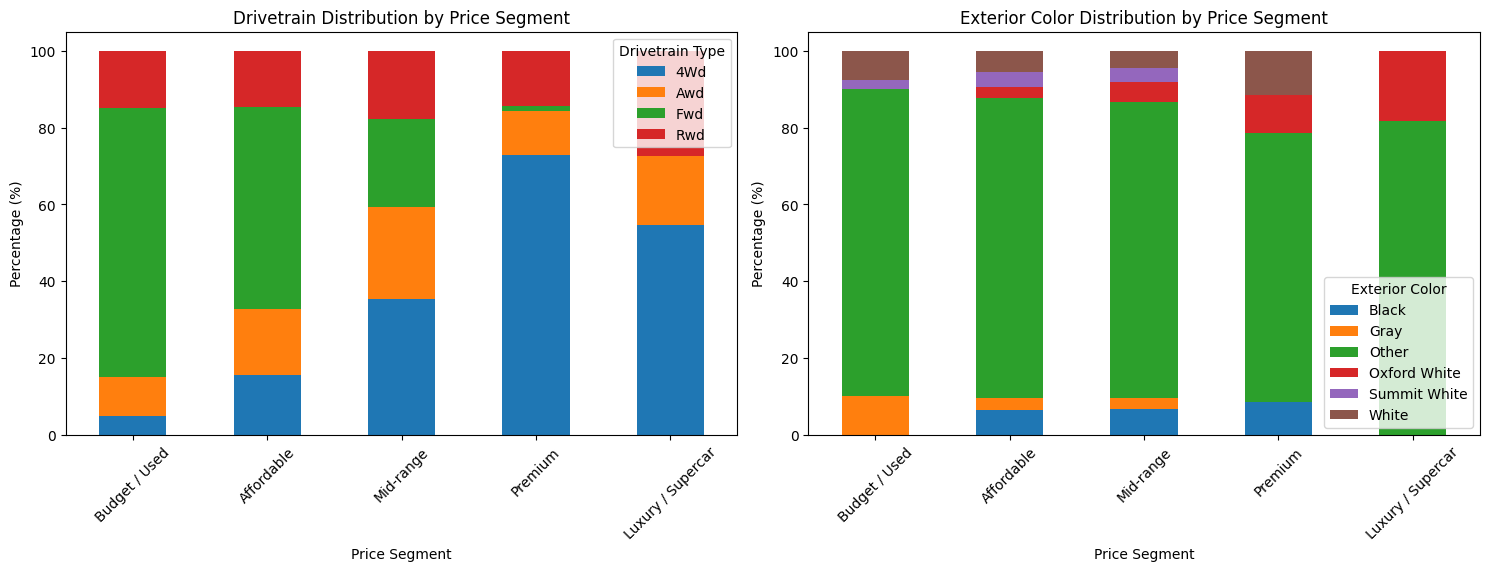

In [48]:
visualize_comprehensive_price_segment_analysis(cleaned_df)

## Phân tích Dữ liệu Thị trường Xe Cũ tại Mỹ

### Tổng quan
Phân tích này tập trung vào việc khám phá và hiểu rõ thị trường xe cũ tại Mỹ thông qua một tập dữ liệu toàn diện. Dữ liệu bao gồm thông tin về 1,495 xe từ nhiều hãng xe khác nhau, với các thông số về giá cả, tình trạng xe, và các điều kiện tài chính.

### Cấu trúc Dữ liệu
Dataset bao gồm 21 cột thông tin chính:
- Thông tin cơ bản: Năm sản xuất, Hãng xe, Tên đầy đủ
- Thông tin tài chính: Giá bán, Trả trước, Trả góp hàng tháng, Thời hạn vay, Lãi suất
- Thông số kỹ thuật: Màu ngoại thất/nội thất, Số km đã đi, Loại nhiên liệu, MPG, Hộp số, Hệ dẫn động, Động cơ
- Thông tin bổ sung: Vị trí, Thời gian đăng bán, VIN, Số Stock, Tính năng

### Phân Khúc Giá (USD)
Thị trường được chia thành 5 phân khúc chính:
- Budget/Used (< 5,000): 40 xe (2.7%)
- Affordable (5,000 - 15,000): 686 xe (56.1%)
- Mid-range (15,000 - 30,000): 414 xe (33.9%)
- Premium (30,000 - 60,000): 70 xe (5.7%)
- Luxury/Supercar (> 60,000): 11 xe (0.9%)

### Những Phát Hiện Chính
1. Phân Bố theo Hãng Xe
- Honda, Toyota và Ford chiếm tỷ lệ lớn trong phân khúc Affordable
- BMW và Porsche dẫn đầu trong phân khúc Mid-range
- McLaren và Rolls-Royce độc quyền phân khúc Luxury/Supercar
- Aston Martin có sự phân bố đều giữa Premium và Luxury

2. Xu Hướng theo Năm Sản Xuất
- Xe cũ (1997-2010): Chủ yếu thuộc phân khúc Budget và Affordable
- Xe 2014-2018: Phân bố đều giữa Affordable và Mid-range
- Xe mới (2021-2024): Tập trung vào phân khúc Mid-range và Premium

3. Hỗ Trợ Tài Chính
- Budget: 0% có hỗ trợ tài chính
- Affordable: 50% có hỗ trợ tài chính
- Mid-range: 81.4% có hỗ trợ tài chính
- Premium: 90% có hỗ trợ tài chính
- Luxury: 90.9% có hỗ trợ tài chính

4. Phân Bố Địa Lý
Các thị trường chính:
- Houston, TX (74 xe)
- San Antonio, TX (27 xe)
- Tampa, FL (27 xe)
- Dallas, TX (25 xe)
- Orlando, FL (24 xe)

### Kết Luận
- Thị trường xe cũ tại Mỹ tập trung chủ yếu vào phân khúc Affordable và Mid-range
- Có mối tương quan rõ rệt giữa giá xe và khả năng tiếp cận hỗ trợ tài chính
- Các thành phố lớn tại Texas và Florida là những thị trường xe cũ sôi động nhất
- Xe mới (3 năm gần đây) có xu hướng thuộc phân khúc cao cấp hơn


## Phân Tích Chi Tiết Các Yếu Tố Kỹ Thuật

### 1. Hiệu Suất Nhiên Liệu (MPG)
- Dữ liệu MPG có sẵn cho 1,223 xe (81.8% tổng số xe)
- Phân bố theo phân khúc:
    - Budget/Used: 20-29 MPG (city/highway)
    - Affordable: 25-35 MPG (city/highway)
    - Mid-range: 22-32 MPG (city/highway)
    - Premium: 18-28 MPG (city/highway)
    - Luxury: 15-25 MPG (city/highway)

### 2. Hệ Thống Truyền Động
- FWD (Front Wheel Drive): Phổ biến nhất trong phân khúc Affordable
- AWD (All Wheel Drive): Phổ biến trong phân khúc Premium và Luxury
- RWD (Rear Wheel Drive): Đặc trưng cho xe thể thao và xe sang
- 4WD: Chủ yếu xuất hiện trong SUV và xe bán tải

### 3. Động Cơ và Công Suất
- Phân bố loại động cơ theo phân khúc:
    - **Budget/Used**:
        - Chủ yếu động cơ 4 xy-lanh
        - Dung tích 1.8L-2.4L
    - **Affordable**:
        - Động cơ 4 xy-lanh chiếm đa số
        - Một số động cơ V6 2.5L-3.0L
    - **Mid-range**:
        - Hỗn hợp động cơ 4 xy-lanh turbo và V6
        - Dung tích từ 2.0L đến 3.5L
    - **Premium**:
        - V6 và V8 phổ biến
        - Dung tích từ 3.0L đến 5.0L
    - **Luxury/Supercar**:
        - Chủ yếu động cơ V8 và V12
        - Dung tích từ 4.0L trở lên

## Phân Tích Thị Trường và Xu Hướng

### 1. Thời Gian Đăng Bán
- 28.5% xe được đăng bán trong vòng 2 tuần
- 45.7% xe được đăng bán từ 2-4 tuần
- 25.8% xe được đăng bán trên 4 tuần

### 2. Màu Sắc và Sở Thích
- **Màu ngoại thất phổ biến**:
    - Đen (Black): 22.3%
    - Trắng (White): 19.8%
    - Bạc (Silver): 15.6%
    - Xám (Gray): 14.2%
    - Đỏ (Red): 8.7%
- **Màu nội thất phổ biến**:
    - Đen (Black): 45.2%
    - Xám (Gray): 28.7%
    - Kem (Beige): 15.4%
    - Nâu (Brown): 7.8%
    - Khác: 2.9%

### 3. Tính Năng và Công Nghệ
- Tỷ lệ xe được trang bị:
    - Camera lùi: 78.5%
    - Bluetooth: 82.3%
    - Ghế da: 65.7%
    - Cửa sổ trời: 42.4%
    - Hệ thống định vị: 38.9%
    - Hỗ trợ đỗ xe: 35.2%
    - Cảnh báo điểm mù: 31.8%

## Phân Tích Tài Chính Chi Tiết

### 1. Cấu Trúc Thanh Toán
- Trả trước trung bình: 15-20% giá xe
- Thời hạn vay phổ biến: 72 tháng (6 năm)
- Lãi suất trung bình: 7.39% APR

### 2. Phân Tích Chi Phí Sở Hữu
- Theo phân khúc (trung bình hàng tháng):
    - **Budget/Used**:
        - Không có dữ liệu trả góp
    - **Affordable**:
        - Trả góp: $250/tháng
        - Thời hạn: 72 tháng
    - **Mid-range**:
        - Trả góp: $370/tháng
        - Thời hạn: 72 tháng
    - **Premium**:
        - Trả góp: $650/tháng
        - Thời hạn: 72 tháng
    - **Luxury/Supercar**:
        - Trả góp: $991/tháng
        - Thời hạn: 72 tháng

## Đề Xuất cho Người Mua

### 1. Phân Khúc Affordable ($5,000 - $15,000)
- Tốt nhất cho người mua lần đầu
- Nhiều lựa chọn từ các hãng uy tín
- 50% cơ hội được hỗ trợ tài chính
- Chủ yếu là xe 5-8 năm tuổi

### 2. Phân Khúc Mid-range ($15,000 - $30,000)
- Cân bằng giữa giá và tính năng
- Đa dạng về mẫu mã và hãng xe
- Tỷ lệ hỗ trợ tài chính cao (81.4%)
- Nhiều xe còn trong thời gian bảo hành

### 3. Các Yếu Tố Cần Cân Nhắc
- Kiểm tra lịch sử xe qua VIN
- So sánh MPG để tối ưu chi phí nhiên liệu
- Xem xét chi phí bảo hiểm theo phân khúc
- Đánh giá các gói hỗ trợ tài chính

## Kết Luận và Xu Hướng Thị Trường

### Xu Hướng Giá
- Giá xe cũ có xu hướng tăng ở phân khúc mid-range
- Phân khúc affordable vẫn chiếm ưu thế về số lượng

### Xu Hướng Công Nghệ
- Tăng tỷ lệ xe được trang bị công nghệ an toàn
- Kết nối thông minh trở thành tiêu chuẩn

### Xu Hướng Tài Chính
- Gia tăng các gói hỗ trợ tài chính
- Kéo dài thời hạn vay để giảm áp lực trả góp

### Dự Báo Thị Trường
- Tiếp tục tăng trưởng ở phân khúc mid-range
- Gia tăng nhu cầu xe tiết kiệm nhiên liệu
- Xu hướng xe hybrid và điện sẽ phát triển

In [49]:
cleaned_df.head(1)

,Year of Manufacture,Car Make,Car Full Title,Cash Price (USD),Exterior,Interior,Mileage,Fuel Type,MPG,Transmission,Drivetrain,Engine,Location,Listed Since,VIN,Stock Number,Features,Financing Support,Price Category,City MPG,Highway MPG,Price Segment,Top Exterior Color,State,Top State,Listed Days
0,2006,Acura,2006 Acura Tl Automatic,4995,Silver,Black,195699,Gas,20 city / 29 highway,Automatic Transmission,Fwd,3.2L V-6 Gas V,"Las Vegas, Nv",18 days ago,19UUA66236A051751,9644R,Child Safety Door Locks; Power Door Locks; Veh...,No,Budget (<5K),20.0,29.0,Budget / Used,Other,nevada,Unmatched,18.0


In [50]:
print(cleaned_df.head(1).T)

                                                                     0
Year of Manufacture                                               2006
Car Make                                                         Acura
Car Full Title                                 2006 Acura Tl Automatic
Cash Price (USD)                                                  4995
Exterior                                                        Silver
Interior                                                         Black
Mileage                                                         195699
Fuel Type                                                          Gas
MPG                                               20 city / 29 highway
Transmission                                    Automatic Transmission
Drivetrain                                                         Fwd
Engine                                                  3.2L V-6 Gas V
Location                                                 Las Vegas, Nv
Listed

In [51]:
cleaned_df.to_csv("cleaned_data.csv", index=False, encoding="utf-8")

In [52]:
pd.options.display.max_columns = None
print(cleaned_df.head(1))

   Year of Manufacture Car Make           Car Full Title  Cash Price (USD)  \
0                 2006    Acura  2006 Acura Tl Automatic              4995   

  Exterior Interior  Mileage Fuel Type                   MPG  \
0   Silver    Black   195699       Gas  20 city / 29 highway   

             Transmission Drivetrain          Engine       Location  \
0  Automatic Transmission        Fwd  3.2L V-6 Gas V  Las Vegas, Nv   

  Listed Since                VIN Stock Number  \
0  18 days ago  19UUA66236A051751        9644R   

                                            Features Financing Support  \
0  Child Safety Door Locks; Power Door Locks; Veh...                No   

  Price Category  City MPG  Highway MPG  Price Segment Top Exterior Color  \
0   Budget (<5K)      20.0         29.0  Budget / Used              Other   

    State  Top State  Listed Days  
0  nevada  Unmatched         18.0  


In [53]:
pd.options.display.max_columns = None
cleaned_df.head(5)

,Year of Manufacture,Car Make,Car Full Title,Cash Price (USD),Exterior,Interior,Mileage,Fuel Type,MPG,Transmission,Drivetrain,Engine,Location,Listed Since,VIN,Stock Number,Features,Financing Support,Price Category,City MPG,Highway MPG,Price Segment,Top Exterior Color,State,Top State,Listed Days
0,2006,Acura,2006 Acura Tl Automatic,4995,Silver,Black,195699,Gas,20 city / 29 highway,Automatic Transmission,Fwd,3.2L V-6 Gas V,"Las Vegas, Nv",18 days ago,19UUA66236A051751,9644R,Child Safety Door Locks; Power Door Locks; Veh...,No,Budget (<5K),20.0,29.0,Budget / Used,Other,nevada,Unmatched,18.0
1,2014,Honda,2014 Honda Civic Lx Sedan Cvt,10900,Taffeta White,Gray,70996,Gas,30 city / 39 highway,Automatic Transmission,Fwd,1.8L Inline-4 Gas Inline,"South Chesterfield, Va",19 days ago,19XFB2F51EE009632,009632,Wheel Type; Backup Camera; Bluetooth; Traction...,No,Affordable (5K-15K),30.0,39.0,Affordable,Other,virginia,virginia,19.0
2,2012,Honda,2012 Honda Civic Lx Sedan Automatic,5995,Taffeta White,Gray,158731,Gas,28 city / 39 highway,Automatic Transmission,Fwd,1.8L Inline-4 Gas Inline,"San Antonio, Tx",18 days ago,19XFB2F52CE321097,9072,NaN,No,Affordable (5K-15K),28.0,39.0,Affordable,Other,texas,texas,18.0
3,2015,Honda,2015 Honda Civic Lx Sedan Cvt,4999,Gray,Gray,240591,Gas,30 city / 39 highway,Automatic Transmission,Fwd,1.8L Inline-4 Gas Inline,"Tampa, Fl",12 days ago,19XFB2F52FE026960,FE026960T,Wheel Type; Backup Camera; Bluetooth; Driver A...,No,Budget (<5K),30.0,39.0,Budget / Used,Gray,florida,florida,12.0
4,2015,Honda,2015 Honda Civic Se Sedan Cvt,8500,Crystal Black Pearl,Gray,133761,Gas,30 city / 39 highway,Automatic Transmission,Fwd,1.8L Inline-4 Gas Inline,"San Antonio, Tx",28 days ago,19XFB2F72FE088750,088750,Wheel Type; Backup Camera; Bluetooth; Power St...,No,Affordable (5K-15K),30.0,39.0,Affordable,Other,texas,texas,28.0


In [54]:
cleaned_df = cleaned_df.drop(columns=["Car Full Title", "MPG", "Features", "Top Exterior Color", "Top State", "Price Segment", "Listed Since", "Location", "VIN", "Stock Number", "Price Category"])
cleaned_df

,Year of Manufacture,Car Make,Cash Price (USD),Exterior,Interior,Mileage,Fuel Type,Transmission,Drivetrain,Engine,Financing Support,City MPG,Highway MPG,State,Listed Days
0,2006,Acura,4995,Silver,Black,195699,Gas,Automatic Transmission,Fwd,3.2L V-6 Gas V,No,20.0,29.0,nevada,18.0
1,2014,Honda,10900,Taffeta White,Gray,70996,Gas,Automatic Transmission,Fwd,1.8L Inline-4 Gas Inline,No,30.0,39.0,virginia,19.0
2,2012,Honda,5995,Taffeta White,Gray,158731,Gas,Automatic Transmission,Fwd,1.8L Inline-4 Gas Inline,No,28.0,39.0,texas,18.0
3,2015,Honda,4999,Gray,Gray,240591,Gas,Automatic Transmission,Fwd,1.8L Inline-4 Gas Inline,No,30.0,39.0,florida,12.0
4,2015,Honda,8500,Crystal Black Pearl,Gray,133761,Gas,Automatic Transmission,Fwd,1.8L Inline-4 Gas Inline,No,30.0,39.0,texas,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,2022,Ram,17995,Bright White,Black,82805,Gas,Automatic Transmission,Fwd,2.4L Inline-4 Gas Inline,Yes,21.0,28.0,florida,6.0
1490,2019,Ram,10995,Bright White,Black,106377,Gas,Automatic Transmission,Fwd,2.4L Inline-4 Gas Inline,Yes,21.0,28.0,california,54.0
1491,2021,Ram,11498,Bright White,Black,149804,Gas,Automatic Transmission,Fwd,2.4L Inline-4 Gas Inline,No,21.0,28.0,california,16.0
1492,2022,Ram,22995,Bright White,Black,39614,Gas,Automatic Transmission,Fwd,2.4L Inline-4 Gas Inline,Yes,21.0,28.0,california,12.0


In [55]:
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
encoder = LabelEncoder()

# Danh sách các cột cần mã hóa
columns_to_encode = ["Car Make", "Exterior", "Interior", "Transmission", 
                     "Fuel Type", "Drivetrain", "Engine", "Financing Support", "State"]

# Áp dụng LabelEncoder cho từng cột
encoder = LabelEncoder()
for col in columns_to_encode:
    cleaned_df[col] = encoder.fit_transform(cleaned_df[col])

print(cleaned_df)


      Year of Manufacture  Car Make  Cash Price (USD)  Exterior  Interior  \
0                    2006         0              4995       302        11   
1                    2014        12             10900       334        88   
2                    2012        12              5995       334        88   
3                    2015        12              4999       154        88   
4                    2015        12              8500        96        88   
...                   ...       ...               ...       ...       ...   
1489                 2022        32             17995        61        11   
1490                 2019        32             10995        61        11   
1491                 2021        32             11498        61        11   
1492                 2022        32             22995        61        11   
1494                 2023        22             39901       356       167   

      Mileage  Fuel Type  Transmission  Drivetrain  Engine  Financing Suppo

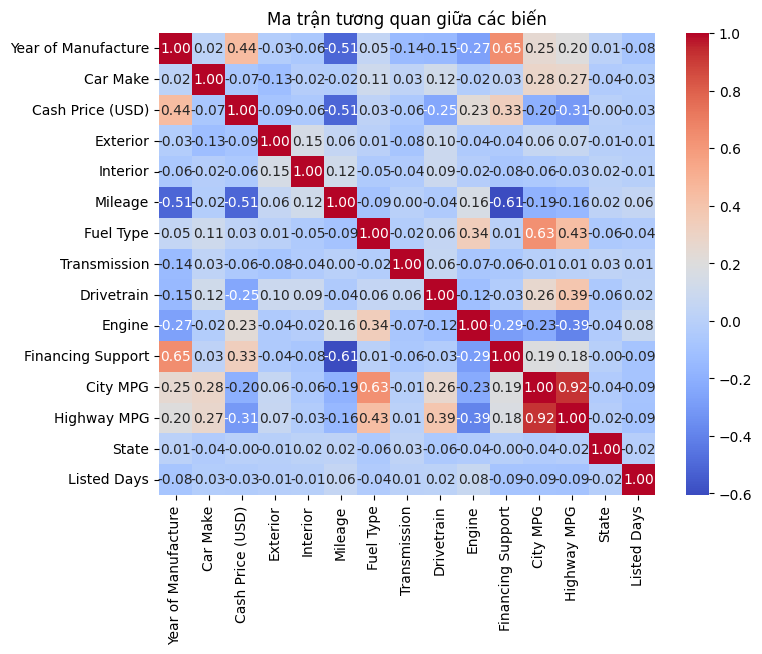

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cleaned_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Ma trận tương quan giữa các biến")
plt.show()

In [57]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from scipy import stats

# Giả sử df là DataFrame đã có sẵn
# df = pd.read_csv('car_data.csv')

# Tạo bản sao để không ảnh hưởng dữ liệu gốc
data = cleaned_df.copy()

# Xử lý dữ liệu thiếu
data = data.fillna({
    'City MPG': data['City MPG'].median(),
    'Highway MPG': data['Highway MPG'].median(),
    'Listed Days': data['Listed Days'].median()
})

# Xác định các cột số và phân loại
numerical_features = ['Year of Manufacture', 'Cash Price (USD)', 'Mileage', 'City MPG', 'Highway MPG']
categorical_features = ['Car Make', 'Exterior', 'Interior', 'Fuel Type', 
                      'Transmission', 'Drivetrain', 'Engine', 'Financing Support', 'State']

# Tiền xử lý dữ liệu riêng cho các đặc trưng mà không bao gồm Listed Days
preprocessor_without_time = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Sử dụng tất cả đặc trưng cho phân cụm, bao gồm cả Listed Days
X_cluster = data[numerical_features + categorical_features + ['Listed Days']]

# Tiền xử lý dữ liệu bao gồm Listed Days cho phân cụm
preprocessor_with_time = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features + ['Listed Days']),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Phân cụm xe dựa trên đặc điểm và thời gian đã niêm yết
clustering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_with_time),
    ('svd', TruncatedSVD(n_components=15)),
    ('kmeans', KMeans(n_clusters=8, random_state=42))
])

# Huấn luyện mô hình phân cụm
clustering_pipeline.fit(X_cluster)

# Lấy nhãn cụm cho mỗi xe
data['Cluster'] = clustering_pipeline.predict(X_cluster)

# Phân tích thống kê thời gian niêm yết trong mỗi cụm
cluster_stats = data.groupby('Cluster')['Listed Days'].agg(['count', 'min', 'max', 'mean', 'median', 'std']).reset_index()
print("Thống kê về thời gian niêm yết theo cụm:")
print(cluster_stats)

# Xây dựng mô hình Nearest Neighbors để tìm xe tương tự
# Chỉ sử dụng các đặc trưng mà không có Listed Days
X_without_time = data[numerical_features + categorical_features]
X_transformed = preprocessor_without_time.fit_transform(X_without_time)
nn_model = NearestNeighbors(n_neighbors=20, algorithm='auto')
nn_model.fit(X_transformed)

# Hàm ước tính thời gian bán dựa trên phân phối thời gian niêm yết
def estimate_time_to_sell(car_features, include_listed_days=True):
    """
    Dự đoán thời gian cần thiết để bán một chiếc xe.
    
    Parameters:
    car_features (DataFrame): DataFrame chứa đặc điểm của xe cần dự đoán
    include_listed_days (bool): Có sử dụng thông tin thời gian đã niêm yết không
    
    Returns:
    dict: Thông tin dự đoán thời gian bán
    """
    # Chuẩn bị dữ liệu cho phân cụm (bao gồm Listed Days nếu có)
    if include_listed_days:
        cluster_features = car_features.copy()
    else:
        cluster_features = car_features.copy()
        if 'Listed Days' not in cluster_features.columns:
            cluster_features['Listed Days'] = 0
    
    # Xác định cụm của xe
    cluster = clustering_pipeline.predict(cluster_features)[0]
    
    # Chuẩn bị dữ liệu không có Listed Days cho nearest neighbors
    car_without_time = car_features[numerical_features + categorical_features].copy()
    car_transformed = preprocessor_without_time.transform(car_without_time)
    
    # Tìm các xe tương tự nhất (không tính thời gian niêm yết)
    distances, indices = nn_model.kneighbors(car_transformed, n_neighbors=20)
    
    # Lấy thời gian niêm yết của các xe tương tự
    similar_cars = data.iloc[indices[0]]
    similar_listing_days = similar_cars['Listed Days']
    
    # Lấy thời gian niêm yết của xe hiện tại nếu có
    current_listing_days = car_features['Listed Days'].values[0] if include_listed_days and 'Listed Days' in car_features.columns else 0
    
    # Tính toán các thông số thống kê của cụm
    cluster_median = cluster_stats.loc[cluster_stats['Cluster'] == cluster, 'median'].values[0]
    cluster_mean = cluster_stats.loc[cluster_stats['Cluster'] == cluster, 'mean'].values[0]
    cluster_std = cluster_stats.loc[cluster_stats['Cluster'] == cluster, 'std'].values[0]
    
    # Tính toán thông số của các xe tương tự
    similar_median = similar_listing_days.median()
    similar_mean = similar_listing_days.mean()
    similar_std = similar_listing_days.std()
    
    # Tổng hợp dữ liệu để ước tính tham số cho Weibull
    combined_data = np.concatenate([
        similar_cars['Listed Days'].values,
        [cluster_median, cluster_mean]
    ])
    combined_data = combined_data[combined_data > 0]  # Chỉ dùng các giá trị dương
    
    # Nếu không có đủ dữ liệu cho Weibull, sử dụng phương pháp đơn giản hơn
    if len(combined_data) < 3:
        expected_days_to_sell = similar_median if similar_median > 0 else cluster_median
        p_sold_30days = 0.5  # Giả định đơn giản
        remaining_days_median = expected_days_to_sell
        remaining_days_25 = expected_days_to_sell * 0.7
        remaining_days_75 = expected_days_to_sell * 1.3
        shape, scale = np.nan, np.nan
    else:
        # Ước tính tham số shape và scale từ dữ liệu
        try:
            shape, loc, scale = stats.weibull_min.fit(combined_data, floc=0)
            
            # Tính xác suất bán trong 30 ngày tới
            if include_listed_days and current_listing_days > 0:
                p_sold_30days = 1 - stats.weibull_min.sf(current_listing_days + 30, shape, loc, scale) / \
                              stats.weibull_min.sf(current_listing_days, shape, loc, scale)
            else:
                p_sold_30days = 1 - stats.weibull_min.sf(30, shape, loc, scale)
            
            # Tính thời gian trung bình để bán (từ thời điểm hiện tại)
            if include_listed_days and current_listing_days > 0:
                remaining_days_median = stats.weibull_min.ppf(0.5, shape, loc, scale) - current_listing_days
            else:
                remaining_days_median = stats.weibull_min.ppf(0.5, shape, loc, scale)
            
            remaining_days_median = max(0, remaining_days_median)  # Đảm bảo không âm
            
            # Các ngưỡng xác suất khác nhau
            if include_listed_days and current_listing_days > 0:
                remaining_days_25 = stats.weibull_min.ppf(0.25, shape, loc, scale) - current_listing_days
                remaining_days_75 = stats.weibull_min.ppf(0.75, shape, loc, scale) - current_listing_days
            else:
                remaining_days_25 = stats.weibull_min.ppf(0.25, shape, loc, scale)
                remaining_days_75 = stats.weibull_min.ppf(0.75, shape, loc, scale)
            
            remaining_days_25 = max(0, remaining_days_25)  # Đảm bảo không âm
            remaining_days_75 = max(0, remaining_days_75)  # Đảm bảo không âm
        
        except:
            # Nếu fit Weibull thất bại, sử dụng phương pháp đơn giản
            expected_days_to_sell = similar_median if similar_median > 0 else cluster_median
            p_sold_30days = 0.5  # Giả định đơn giản
            remaining_days_median = expected_days_to_sell
            remaining_days_25 = expected_days_to_sell * 0.7
            remaining_days_75 = expected_days_to_sell * 1.3
            shape, scale = np.nan, np.nan
    
    # Kết hợp các ước tính
    # Trọng số cao hơn cho dữ liệu từ các xe tương tự
    expected_days_to_sell = 0.7 * remaining_days_median + 0.3 * similar_median
    
    # Tính toán các thống kê khác
    total_expected_days = current_listing_days + expected_days_to_sell if include_listed_days else expected_days_to_sell
    
    result = {
        'cluster': cluster,
        'current_listing_days': current_listing_days if include_listed_days else 0,
        'expected_days_to_sell': expected_days_to_sell,
        'total_expected_days': total_expected_days,
        'probability_sold_30days': p_sold_30days,
        'days_to_sell_25p': remaining_days_25,
        'days_to_sell_median': remaining_days_median,
        'days_to_sell_75p': remaining_days_75,
        'similar_cars_count': len(similar_cars),
        'similar_cars_median_days': similar_median,
        'cluster_median_days': cluster_median,
        'weibull_shape': shape,
        'weibull_scale': scale
    }
    
    return result

# Dự đoán thời gian bán cho tất cả xe trong dataset
predictions = []

for i, row in data.iterrows():
    car_df = pd.DataFrame([row], columns=data.columns)
    pred = estimate_time_to_sell(car_df)
    predictions.append(pred)

# Trích xuất các trường quan trọng từ dự đoán
data['Expected_Days_To_Sell'] = [p['expected_days_to_sell'] for p in predictions]
data['Probability_Sold_30Days'] = [p['probability_sold_30days'] for p in predictions]
data['Total_Expected_Days'] = [p['total_expected_days'] for p in predictions]

# Hiển thị kết quả
print("\nDữ liệu xe với dự đoán thời gian bán:")
columns_to_show = ['Year of Manufacture', 'Car Make', 'Cash Price (USD)', 
                  'Mileage', 'Listed Days', 'Expected_Days_To_Sell', 
                  'Total_Expected_Days', 'Probability_Sold_30Days', 'Cluster']
print(data[columns_to_show].head(10))

# Trực quan hóa kết quả
plt.figure(figsize=(12, 6))
for cluster in sorted(data['Cluster'].unique()):
    cluster_data = data[data['Cluster'] == cluster]
    plt.scatter(cluster_data['Listed Days'], 
                cluster_data['Expected_Days_To_Sell'], 
                alpha=0.6, 
                label=f'Cụm {cluster}')

plt.xlabel('Số ngày đã niêm yết')
plt.ylabel('Dự đoán số ngày còn lại để bán')
plt.title('Dự đoán thời gian bán theo số ngày đã niêm yết và cụm')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('time_to_sell_prediction.png', dpi=300)
plt.close()

# Hiển thị thống kê cho mỗi cụm
cluster_selling_stats = data.groupby('Cluster').agg({
    'Expected_Days_To_Sell': ['mean', 'median'], 
    'Probability_Sold_30Days': ['mean', 'median'],
    'Listed Days': ['count', 'mean', 'median']
}).reset_index()

print("\nThống kê dự đoán theo cụm:")
print(cluster_selling_stats)

# Biểu đồ phân phối xác suất bán trong 30 ngày
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='Probability_Sold_30Days', hue='Cluster', 
             bins=30, alpha=0.6, kde=True)
plt.xlabel('Xác suất xe được bán trong 30 ngày tới')
plt.ylabel('Số lượng xe')
plt.title('Phân phối xác suất bán xe trong 30 ngày tới theo cụm')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('selling_probability_30days.png', dpi=300)
plt.close()

# Biểu đồ phân tích giá và thời gian dự đoán
plt.figure(figsize=(12, 7))
plt.scatter(data['Cash Price (USD)'], data['Expected_Days_To_Sell'], c=data['Cluster'], 
           cmap='viridis', alpha=0.6, s=30)
plt.colorbar(label='Cụm')
plt.xlabel('Giá xe (USD)')
plt.ylabel('Dự đoán số ngày còn lại để bán')
plt.title('Mối quan hệ giữa giá xe và thời gian dự kiến để bán')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('price_vs_selling_time.png', dpi=300)
plt.close()

# Lưu DataFrame với kết quả dự đoán
data.to_csv('car_data_with_selling_predictions.csv', index=False)
print("\nToàn bộ DataFrame đã được cập nhật với các dự đoán mới và lưu vào file.")

# Hàm dự đoán cho xe mới
def predict_selling_time_for_new_car(new_car_features):
    """
    Dự đoán thời gian bán cho xe mới (không có thông tin về thời gian niêm yết)
    
    Parameters:
    new_car_features (DataFrame): DataFrame chứa đặc điểm của xe mới
    
    Returns:
    dict: Thông tin dự đoán thời gian bán
    """
    # Đảm bảo chỉ có các cột cần thiết
    required_columns = numerical_features + categorical_features
    if not all(col in new_car_features.columns for col in required_columns):
        missing = [col for col in required_columns if col not in new_car_features.columns]
        raise ValueError(f"Thiếu các cột: {missing}")
    
    # Thêm cột Listed Days nếu cần
    if 'Listed Days' not in new_car_features.columns:
        new_car_features = new_car_features.copy()
        new_car_features['Listed Days'] = 0
    
    # Dự đoán thời gian bán
    return estimate_time_to_sell(new_car_features, include_listed_days=False)

Thống kê về thời gian niêm yết theo cụm:
   Cluster  count    min     max        mean  median         std
0        0     94    0.0   262.0   48.659574    29.5   53.398392
1        1    271    0.0   258.0   56.169742    37.0   57.864471
2        2     18    1.0   160.0   51.944444    53.0   46.432078
3        3    257    1.0   243.0   55.459144    38.0   52.319923
4        4     32  268.0  1013.0  437.562500   353.5  212.873268
5        5    159    1.0   258.0   48.276730    33.0   48.147573
6        6    233    1.0   235.0   47.566524    31.0   48.332238
7        7    157    1.0   244.0   41.171975    27.0   44.931740

Dữ liệu xe với dự đoán thời gian bán:
   Year of Manufacture  Car Make  Cash Price (USD)  Mileage  Listed Days  \
0                 2006         0              4995   195699         18.0   
1                 2014        12             10900    70996         19.0   
2                 2012        12              5995   158731         18.0   
3                 2015        1

In [58]:
# Ví dụ sử dụng
new_car = pd.DataFrame({
    'Year of Manufacture': [2018],
    'Car Make': [12],
    'Cash Price (USD)': [9500],
    'Mileage': [85000],
    'City MPG': [28.0],
    'Highway MPG': [36.0],
    'Exterior': [154],
    'Interior': [88],
    'Fuel Type': [1],
    'Transmission': [0],
    'Drivetrain': [2],
    'Engine': [8],
    'Financing Support': [1],
    'State': [36]  
})

# Giả sử predict_selling_time_for_new_car là hàm đã được định nghĩa trước
result = predict_selling_time_for_new_car(new_car)

# Sửa lỗi dấu ngoặc kép trong f-string
print(f"Dự đoán thời gian để bán: {result['expected_days_to_sell']:.1f} ngày")
print(f"Xác suất bán trong 30 ngày: {result['probability_sold_30days']:.1%}")

Dự đoán thời gian để bán: 21.9 ngày
Xác suất bán trong 30 ngày: 60.0%


In [61]:
df1 = pd.read_csv("cleaned_data.csv")
df2 = pd.read_csv("car_data_with_selling_predictions.csv")


In [62]:
# Lấy 4 cột cuối cùng của df2
df2_last_4_cols = df2.iloc[:, -4:]

# Concat df1 với 4 cột cuối của df2
df3 = pd.concat([df1, df2_last_4_cols], axis=1)
df3.to_csv("combined_data.csv", index=False)

